# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using PyTorch, using the following environment set up

# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using PyTorch, using the following environment set up

In [1]:
import sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pennylane as qml
from scipy import optimize

# Append custom classes to  sys.path

sys.path.append('../static/py/classes/')
from classic_models import FCN
from quantum_models import QuantumModelsTwoQubits
from hybrid_models import HybridQNN
from visualization import Visualization 

In [2]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


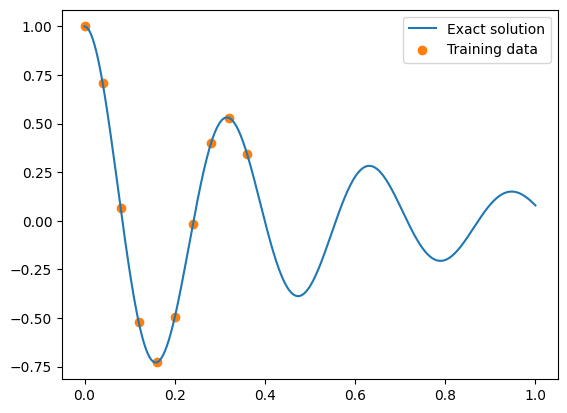

In [3]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
data = list(zip(x_data, y_data))
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Quantum Hybrid Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points. AN after using a VQC like a quantum last layer. The Loss Function is a MSE.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [8]:
# train standard neural network to fit training data
torch.manual_seed(123)
classic_model = FCN(1,1,32,3)

quantum_model =  QuantumModelsTwoQubits().vqc_three

classic_w  = classic_model.parameters()
quantum_w = (2*np.pi*np.random.rand(10) - np.pi)

def quantum_hybrid_model(x,w):
    classic_output = classic_model(x)
    return quantum_model(classic_output.detach().numpy().reshape(-1),w)

def average_loss(w):
    losses = 0
    losses_ic = 0
    i = 0
    for x, y in data:
        losses += (quantum_hybrid_model(x, w) - y.numpy()) ** 2
        # print(qml.draw(model)(x,w))
        if  i ==0 :
            losses_ic= (quantum_hybrid_model(x,w)-y.numpy())**2
        i += 1
    return losses/len(data) + losses_ic


gradient_fn_w = qml.grad(average_loss, argnum=0)
hessian_fn_w = qml.jacobian(gradient_fn_w, argnum=0)
    

In [4]:
# Using double minimize

optimizer = torch.optim.Adam(classic_w,lr=1e-3)
files = []
lr= 0.01
for i in range(1000):
    # Optimize classic model
    optimizer.zero_grad()
    classic_yh = classic_model(x_data)
    loss = torch.mean((classic_yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()

    # Optimize hybrid model with Gradient Descent Method, Only optimize the quantum part, the classic weights is equal allways with you first random.
    print(average_loss(quantum_w))
    quantum_w = quantum_w - lr*gradient_fn_w(quantum_w)
    if (i+ 1) % 100 == 0:
        hybrid_yh = quantum_hybrid_model(x,quantum_w)
        quantum_loss =  average_loss(quantum_w)
        print("epoch", i + 1, "loss", quantum_loss)
        Visualization.plot_result(i + 1, quantum_loss,x, y, x_data,y_data, hybrid_yh)

NameError: name 'classic_w' is not defined

In [ ]:
# Optimice only quantum parameters with BFGS method --> Cuasi Newton method


def print_log(quantum_w):
    global iteration
    global fout
    fout.write('At iterate {iteration:4d},  loss={loss: 3.6f}, weights ={weights} \n'.format(
        iteration=iteration, loss=average_loss(quantum_w)[0], weights=quantum_w))
    # print('At iterate {iteration:4d},  loss={loss: 3.6f}, weights ={weights} \n'.format(iteration = iteration, loss = average_loss(w),weights = w ))
    iteration += 1


iteration = 1

fout = open('../../../../logs/BFGS_steps_hybrid_QPINN.txt', 'w')
optimize_losses = optimize.minimize(
    average_loss, quantum_w, method='BFGS', jac=gradient_fn_w, callback=print_log, options={'disp': True})

fout.close()

# evaluate solution
print(optimize_losses['x'])
# evaluate solution
solution = optimize_losses['x']
evaluation = average_loss(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
yh = quantum_hybrid_model(x, solution)
Visualization.plot_result(
    optimize_losses['nit'], evaluation, x, y, x_data, y_data, yh)


## Quantum Hybrid Physics Informed Neural Network


In [ ]:
# train standard neural network to fit training data
torch.manual_seed(123)
classic_model = FCN(1, 1, 32, 3)
# sample locations over the problem domain


# sample locations over the problem domain
x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# x_physics = np.linspace(0, 1, 30, requires_grad=True)
# x_physics = np.array([-2., -0.2, 0.,0.5, -1, -0.2], requires_grad = True)
mu, k = 2*d, w0**2

quantum_model = QuantumModelsTwoQubits().vqc_three

classic_w = classic_model.parameters()
quantum_w = (2*np.pi*np.random.rand(10) - np.pi)


def quantum_hybrid_model(x, w):
    classic_output = classic_model(x)
    return quantum_model(classic_output.detach().numpy().reshape(-1), w)


def average_loss(w):
    losses = 0
    losses_ic = 0
    i = 0
    for x, y in data:
        losses += (quantum_hybrid_model(x, w) - y.numpy()) ** 2
        # print(qml.draw(model)(x,w))
        if  i ==0 :
            losses_ic= (quantum_hybrid_model(x,w)-y.numpy())**2
        i += 1
    return losses/len(data) + losses_ic


In [ ]:
# Optimice only quantum parameters

gradient_fn_w = qml.grad(average_loss, argnum=0)
hessian_fn_w = qml.jacobian(gradient_fn_w, argnum=0)

def print_log(quantum_w):
    global iteration
    global fout
    fout.write('At iterate {iteration:4d},  loss={loss: 3.6f}, weights ={weights} \n'.format(
        iteration=iteration, loss=average_loss(quantum_w)[0], weights=quantum_w))
    # print('At iterate {iteration:4d},  loss={loss: 3.6f}, weights ={weights} \n'.format(iteration = iteration, loss = average_loss(w),weights = w ))
    iteration += 1


iteration = 1

fout = open('../../../../logs/BFGS_steps_hybrid_QPINN.txt', 'w')
optimize_losses = optimize.minimize(average_loss, quantum_w, method='BFGS', jac=gradient_fn_w, callback=print_log, options={'disp': True})
# optimize_losses = optimize.minimize(average_loss, quantum_w, method='BFGS', jac=gradient_fn_w, options={'disp': True})

fout.close()

# evaluate solution
print(optimize_losses['x'])
# evaluate solution
solution = optimize_losses['x']
evaluation = average_loss(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
yh = quantum_hybrid_model(x, solution)
Visualization.plot_result(optimize_losses['nit'], evaluation, x, y, x_data, y_data, yh)


In [ ]:
# Using double minimize

optimizer = torch.optim.Adam(classic_w,lr=1e-3)
files = []
lr= 0.01
for i in range(10000):
    # Optimize classic model
    optimizer.zero_grad()

    # # compute the "data loss"
    classic_yh = classic_model(x_data)
    loss1 = torch.mean((classic_yh-y_data)**2)# use mean squared error

    # compute the "physics loss"
    classic_yhp = classic_model(x_physics)
    dx  = torch.autograd.grad(classic_yhp, x_physics, torch.ones_like(classic_yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*classic_yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    #loss2 = (1e-3)*torch.mean(physics**2)
    #loss1= 0 #Se elimina la dependencia de datos experimentales, se debe dejar, al menos, la condición inicial.
    #loss2 = 0 #Se elimina la contribución de la ecuación gobernante física
    
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()

    # Optimize hybrid model
    print(average_loss(quantum_w))
    quantum_w = quantum_w - lr*gradient_fn_w(quantum_w)
    if (i+ 1) % 100 == 0:
        hybrid_yh = quantum_hybrid_model(x,quantum_w)
        quantum_loss =  average_loss(quantum_w)
        print("epoch", i + 1, "loss", quantum_loss)
        Visualization.plot_result(i + 1, quantum_loss,x, y, x_data,y_data, hybrid_yh)

# Hybrid PINNS with last quantum layer in forward for classic neural network

In [5]:
# train standard neural network to fit training data
torch.manual_seed(123)
#model = FCN(1,1,32,3)
n_qubits = 2
model = HybridQNN(1,1,32,3)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(2000):
    optimizer.zero_grad()
    print(x_data)
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        Visualization.plot_result(i+1,loss,x,y,x_data,y_data,yh,)
        
        file = "../../../../media/harmonic_oscillator/plots/hybrid_qnn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 20 == 0: plt.show()
        else: plt.close("all")
            
Visualization.save_gif("../../../../media/harmonic_oscillator/gifs/hybrid_qnn.gif", files, fps=20, loop=0)

tensor([[0.0000],
        [0.0401],
        [0.0802],
        [0.1202],
        [0.1603],
        [0.2004],
        [0.2405],
        [0.2806],
        [0.3206],
        [0.3607]])
entro al forward
tensor([[ 0.0332],
        [ 0.0246],
        [ 0.0161],
        [ 0.0078],
        [-0.0003],
        [-0.0083],
        [-0.0160],
        [-0.0235],
        [-0.0308],
        [-0.0379]], grad_fn=<AddmmBackward0>)
[0.03320805]
*****************
Parameter containing:
tensor([ 0.3862, -0.9211,  0.9879, -0.6062, -0.4917, -0.6350,  0.2742, -1.2074,
        -1.4866, -1.5443], requires_grad=True)
0.3862448036670685
-0.9211220741271973
entro al circuito cuantico
[0.03320805]
0.3862448036670685
[0.01282644]


d:\r_repositorios\quantum_pinns_applications\harmonic_oscillator\src\notebooks\../static/py/classes\hybrid_models.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(quantum_model(x, self.q_weights), dtype=torch.float32)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
# Crear datos de ejemplo
X = torch.rand(100, 2)  # Datos de entrada (100 muestras, 2 características)
y = (X[:, 0] + X[:, 1] > 1).float().unsqueeze(1)  # Etiquetas binarias

# Crear el modelo
model = HybridQNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# Entrenamiento
for epoch in range(100):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")